# Weather Data Cleaning and Imputation

## Imports

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

sns.set_palette('Blues_r')

## Load Weather Data

In [3]:
weather1 = pd.read_csv('./Raw_Data/Weather Data ONTARIO-2023.csv')
weather2 = pd.read_csv('./Raw_Data/Weather Data ONTARIO-2024.csv')
# remove data outside consideration
weather1 = weather1.drop(weather1.iloc[:23].index)
weather1.columns = weather1.iloc[0]
weather1 = weather1.drop(23)

weather2 = weather2.drop(weather2.iloc[:23].index)
weather2.columns = weather2.iloc[0]
weather2 = weather2.drop(23)

# only select Non-Empty rows
symbol = weather1['Data Quality'].unique()[0]
weather1.drop(weather1[weather1['Data Quality'] != symbol].index,inplace = True)
weather1.index = weather1['Date/Time']
weather1.drop(['Date/Time','Data Quality'],axis = 1,inplace = True)

weather2 = weather2.drop(weather2[weather2['Data Quality'].isna()].index)
weather2.index = weather2['Date/Time']
weather2 = weather2.drop(['Date/Time','Data Quality'],axis = 1)

## Data Cleaning

In [4]:
# remove empty and NaN columns
weather1 = weather1.drop(['Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days Flag',
                          'Cool Deg Days Flag','Total Rain Flag','Total Snow Flag','Total Precip Flag',
                          'Snow on Grnd Flag','Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag','Spd of Max Gust (km/h)',
                          'Spd of Max Gust Flag','Year','Month','Day'],axis = 1)

weather2 = weather2.drop(['Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days Flag',
                          'Cool Deg Days Flag','Total Rain Flag','Total Snow Flag','Total Precip Flag',
                          'Snow on Grnd Flag','Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag','Spd of Max Gust (km/h)',
                          'Spd of Max Gust Flag','Year','Month','Day'],axis = 1)

In [5]:
# Combine the data
weather = pd.concat([weather1,weather2])
weather.index = weather.index.astype('datetime64[ns]')
weather = weather.astype(float)
weather.columns.name = None
# Change the index to span 2 years (helpful for interpolation)
weather.index = pd.to_datetime(weather.index)
date_range = pd.date_range(start=weather.index.min(),end = weather.index.max(),freq = 'D')
weather =  weather.reindex(date_range)
weather.head(5)

,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
2023-01-01,0.0,-8.5,-4.3,22.3,0.0,0.0,0.0,0.0,0.0
2023-01-02,-4.0,-6.0,-5.0,23.0,0.0,0.0,15.0,15.0,8.0
2023-01-03,-2.5,-12.5,-7.5,25.5,0.0,0.0,1.0,1.0,27.0
2023-01-04,15.0,0.0,7.5,10.5,0.0,0.0,0.0,0.0,0.0
2023-01-05,22.0,6.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0


# Analyse Weather Data

In [6]:
print('Total number of Days: ',weather.shape[0],'\n')
print('Missing Data:\n')
print(weather.isna().sum())

Total number of Days:  731 

Missing Data:

Max Temp (°C)         289
Min Temp (°C)         322
Mean Temp (°C)        322
Heat Deg Days (°C)    322
Cool Deg Days (°C)    322
Total Rain (mm)       275
Total Snow (cm)       275
Total Precip (mm)     275
Snow on Grnd (cm)     275
dtype: int64


# Interpolate Weather Data

## Temperature Data

In [7]:
df_filled = weather.copy()

#For temperature columns, use linear interpolation with some additional logic
temp_columns = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)']
for col in temp_columns:
    # First, use linear interpolation for small gaps (up to 3 days)
    df_filled[col] = df_filled[col].interpolate(method='linear', limit=3)

    # For larger gaps, use seasonal interpolation
    df_filled[col] = df_filled[col].interpolate(method='time')

    # Add some random noise to simulate variation
    mask = df_filled[col].isna()
    if mask.any():
        noise = np.random.normal(0, 0.5, size=len(df_filled[mask]))
        df_filled.loc[mask, col] = df_filled.loc[mask, col] + noise

#Calculate Mean Temp if missing but Max and Min are available
mask = df_filled['Mean Temp (°C)'].isna() & df_filled['Max Temp (°C)'].notna() & df_filled['Min Temp (°C)'].notna()
df_filled.loc[mask, 'Mean Temp (°C)'] = (df_filled.loc[mask, 'Max Temp (°C)'] + df_filled.loc[mask, 'Min Temp (°C)']) / 2

In [8]:
# Kolmogorov-Smirnov test
print("Distribution Comparison Tests:")
print("-" * 30)
for column in temp_columns:
    ks_stat, ks_p = stats.ks_2samp(
        weather[column].dropna(),
        df_filled.loc[weather[column].dropna().index, column]
    )
    print(f"Kolmogorov-Smirnov Test for {column}:")
    print(f"Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    print(f"Distributions are {'similar' if ks_p > 0.05 else 'different'}")


Distribution Comparison Tests:
------------------------------
Kolmogorov-Smirnov Test for Max Temp (°C):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar
Kolmogorov-Smirnov Test for Min Temp (°C):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar
Kolmogorov-Smirnov Test for Mean Temp (°C):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar


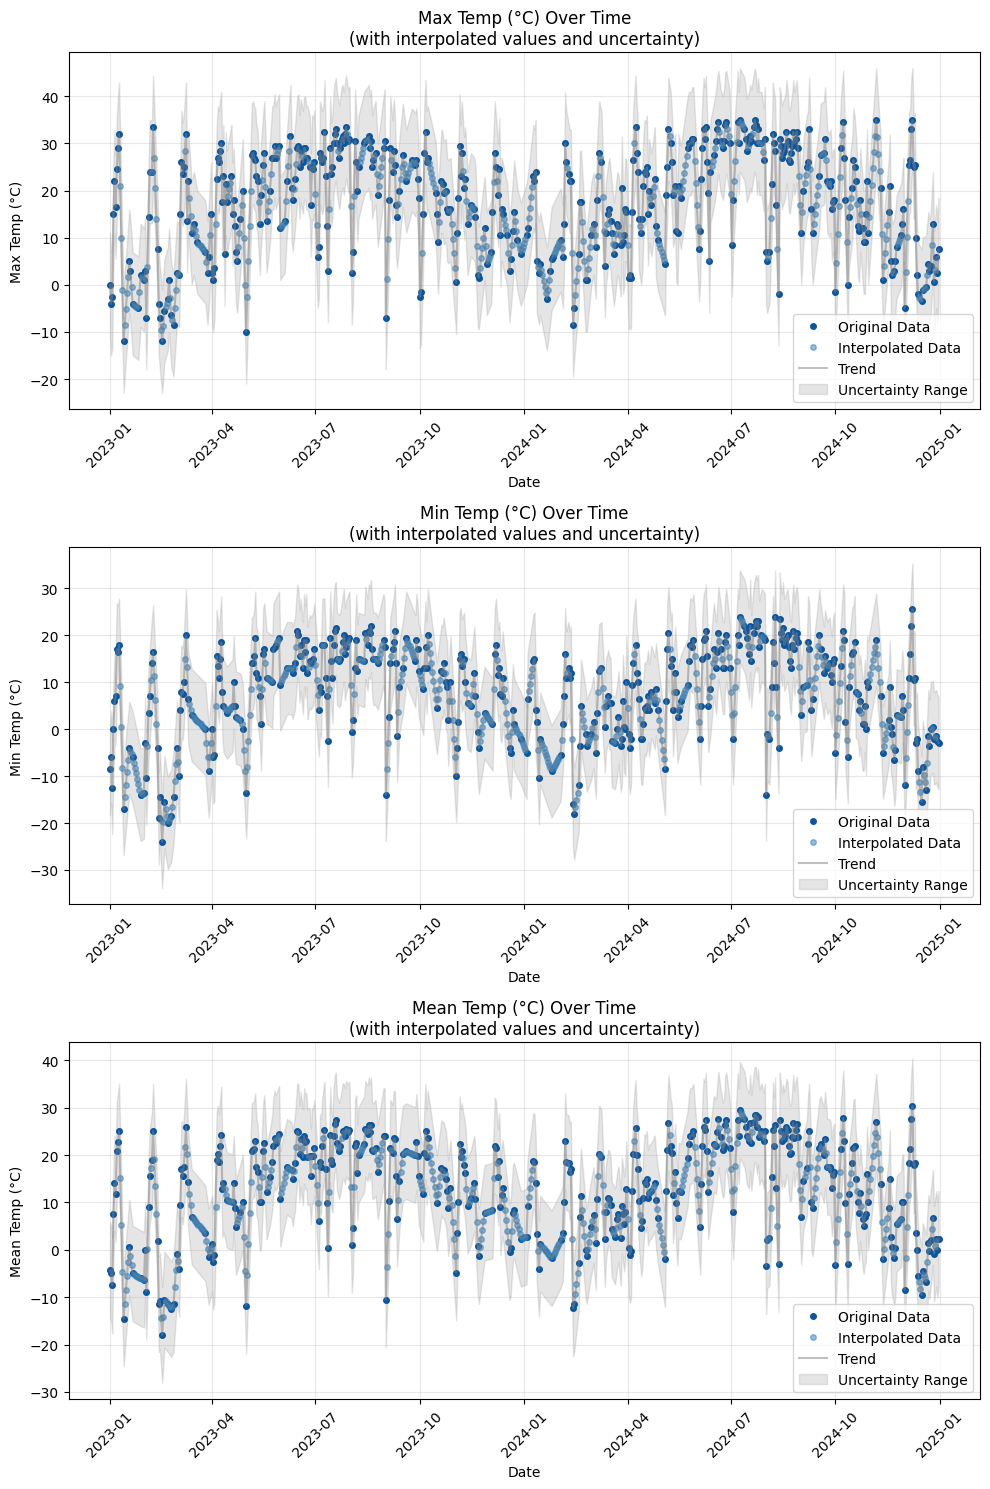

In [9]:
# Create a figure with three subplots arranged vertically
plt.figure(figsize=(10, 15))

for idx, temp_column in enumerate(temp_columns, 1):
    plt.subplot(3, 1, idx)

    # Plot original data points
    plt.plot(weather.index, weather[temp_column], 'o', label='Original Data', markersize=4)

    # Plot interpolated data
    mask = weather[temp_column].isna()
    plt.plot(df_filled.index[mask], df_filled[temp_column][mask], 'o', label='Interpolated Data', alpha=0.5, markersize=4)

    # Plot trend line
    plt.plot(df_filled.index, df_filled[temp_column], '-', color='gray', alpha=0.5, label='Trend')

    # Add confidence interval
    std_dev = df_filled[temp_column].std()
    plt.fill_between(df_filled.index,
                     df_filled[temp_column] - std_dev,
                     df_filled[temp_column] + std_dev,
                     alpha=0.2, color='gray', label='Uncertainty Range')

    plt.title(f'{temp_column} Over Time\n(with interpolated values and uncertainty)')
    plt.xlabel('Date')
    plt.ylabel(f'{temp_column}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Precipitation Data

In [10]:
#Handle precipitation columns with enhanced methods
precip_columns = ['Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']

for col in precip_columns:
    #Handle small gaps with linear interpolation (up to 2 days)
    df_filled[col] = df_filled[col].interpolate(method='linear', limit=2)

    #Use seasonal patterns for larger gaps
    #Calculate rolling median for the same week in different years
    df_filled[col + '_seasonal'] = df_filled[col].groupby(df_filled.index.isocalendar().week).transform('median')

    #Fill remaining gaps with seasonal median, adding small random variation
    mask = df_filled[col].isna()
    if mask.any():
        seasonal_values = df_filled.loc[mask, col + '_seasonal']
        noise_scale = df_filled[col].std() * 0.1 if df_filled[col].std() > 0 else 0.1
        noise = np.random.normal(0, noise_scale, size=len(seasonal_values))
        filled_values = np.maximum(0, seasonal_values + noise)
        df_filled.loc[mask, col] = filled_values
        
    df_filled = df_filled.drop(col + '_seasonal', axis=1)

#Ensure consistency between precipitation measurements
#Total Precip should be >= Total Rain
mask = df_filled['Total Precip (mm)'] < df_filled['Total Rain (mm)']
df_filled.loc[mask, 'Total Precip (mm)'] = df_filled.loc[mask, 'Total Rain (mm)']

In [11]:
print("Distribution Comparison Tests:")
print("-" * 30)
for column in precip_columns:
    ks_stat, ks_p = stats.ks_2samp(
        weather[column].dropna(),
        df_filled.loc[weather[column].dropna().index, column]
    )
    print(f"Kolmogorov-Smirnov Test for {column}:")
    print(f"Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    print(f"Distributions are {'similar' if ks_p > 0.05 else 'different'}")

Distribution Comparison Tests:
------------------------------
Kolmogorov-Smirnov Test for Total Rain (mm):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar
Kolmogorov-Smirnov Test for Total Snow (cm):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar
Kolmogorov-Smirnov Test for Total Precip (mm):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar
Kolmogorov-Smirnov Test for Snow on Grnd (cm):
Statistic: 0.0000, p-value: 1.0000
Distributions are similar


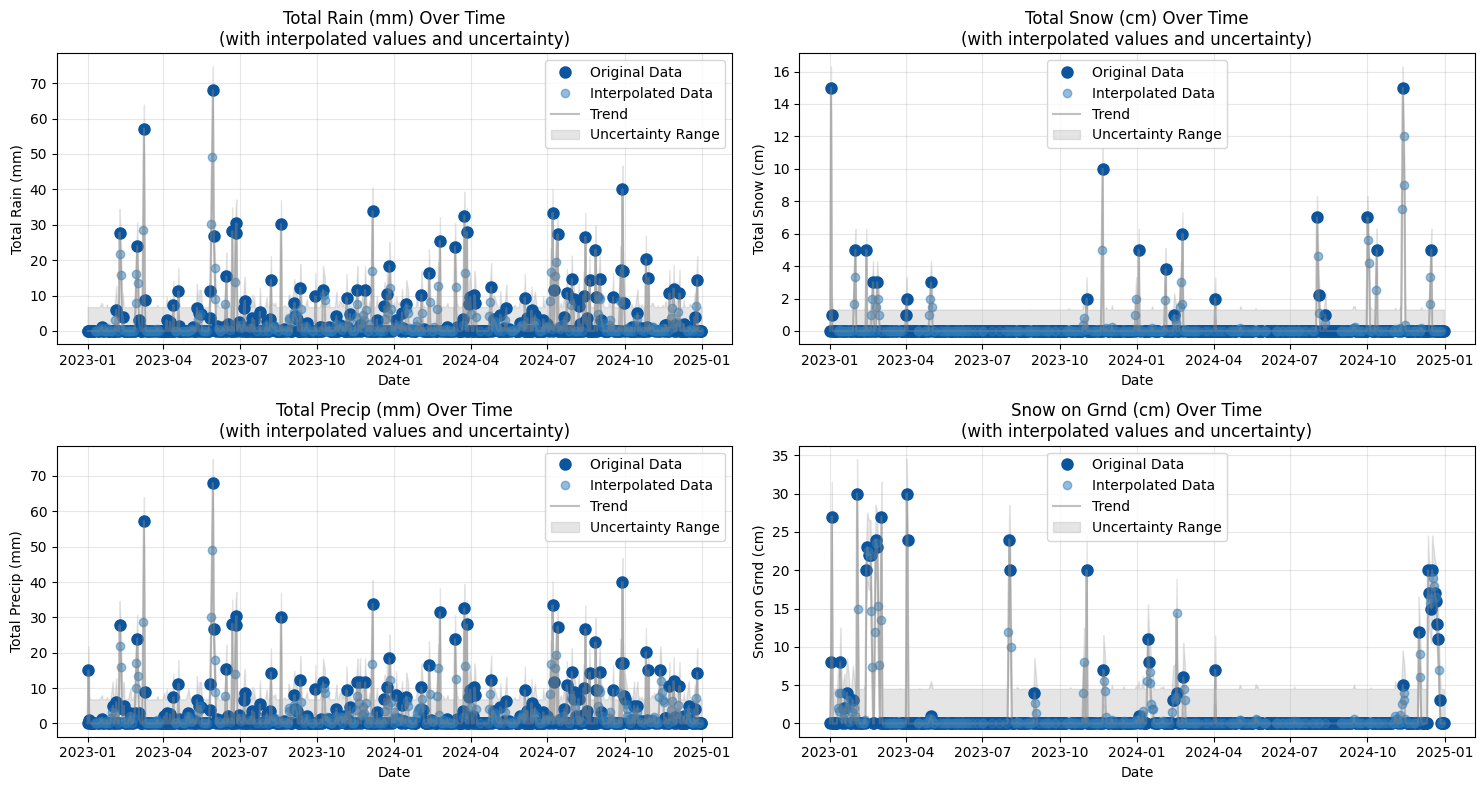

In [12]:
def plot_precipitation_interpolation(df, df_filled, column,plt):
    plt.plot(df.index, df[column], 'o', label='Original Data', markersize=8)
    mask = df[column].isna()
    plt.plot(df_filled.index[mask], df_filled[column][mask], 'o',
             label='Interpolated Data', alpha=0.5, markersize=6)
    plt.plot(df_filled.index, df_filled[column], '-',
             color='gray', alpha=0.5, label='Trend')
    std_dev = df_filled[column].std()
    plt.fill_between(df_filled.index,
                    np.maximum(0, df_filled[column] - std_dev),  # Ensure non-negative
                    df_filled[column] + std_dev,
                    alpha=0.2, color='gray', label='Uncertainty Range')

    plt.set_title(f'{column} Over Time\n(with interpolated values and uncertainty)')
    plt.set_xlabel('Date')
    plt.set_ylabel(column)
    plt.grid(True, alpha=0.3)
    plt.legend()

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()
for idx, column in enumerate(precip_columns, 1):
    plot_precipitation_interpolation(weather, df_filled, column,axs[idx-1])

plt.tight_layout()
plt.show()

## Degree Days Calculation

In [13]:
# Simple function to calculate Heat and Cool Degree Days
base_temp = 18  # °C
# Calculate Heat Degree Days (when mean temp is below base temp)
# For each row where Mean Temp is available but Heat Deg Days is missing
mask = df_filled['Mean Temp (°C)'].notna() & df_filled['Heat Deg Days (°C)'].isna()
df_filled.loc[mask, 'Heat Deg Days (°C)'] = df_filled.loc[mask, 'Mean Temp (°C)'].apply(lambda x: max(0, base_temp - x))

# Calculate Cool Degree Days (when mean temp is above base temp)
# For each row where Mean Temp is available but Cool Deg Days is missing
mask = df_filled['Mean Temp (°C)'].notna() & df_filled['Cool Deg Days (°C)'].isna()
df_filled.loc[mask, 'Cool Deg Days (°C)'] = df_filled.loc[mask, 'Mean Temp (°C)'].apply(lambda x: max(0, x - base_temp))

# Display the results
print("Missing data after filling in missing degree days:\n")
print(df_filled.isna().sum())

Missing data after filling in missing degree days:

Max Temp (°C)         0
Min Temp (°C)         0
Mean Temp (°C)        0
Heat Deg Days (°C)    0
Cool Deg Days (°C)    0
Total Rain (mm)       0
Total Snow (cm)       0
Total Precip (mm)     0
Snow on Grnd (cm)     0
dtype: int64


# Export the Dataset

In [14]:
df_filled = df_filled.query("index >= '2023-07-01' and index <= '2024-06-30'")
df_filled.head(5)

,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm)
2023-07-01,19.333333,13.75,17.625,0.375,0.0,1.6,0.0,1.6,0.0
2023-07-02,12.666667,10.50,13.750,4.250,0.0,0.8,0.0,0.8,0.0
2023-07-03,6.000000,7.25,9.875,8.125,0.0,0.0,0.0,0.0,0.0
2023-07-04,8.000000,4.00,6.000,12.000,0.0,0.4,0.0,0.4,0.0
2023-07-05,28.000000,9.00,18.500,0.000,0.5,0.0,0.0,0.0,0.0


In [15]:
df_filled.to_csv('./Data/weather_combined.csv')